In [1]:
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle
import json
from database.comet import Comet
from processor.processor import Processor as p
from time import sleep
import matplotlib.pyplot as plt
import math
from backtester.entry import Entry
from backtester.exit_strats import ExitStrats

In [2]:
comet = Comet()

In [3]:
comet.connect()
prices = comet.retrieve(f"alpha_prices")
comet.disconnect()

In [4]:
prices["crypto"].unique()

array(['ADA', 'BTC', 'CAKE', 'DOGE', 'ETH', 'SHIB', 'XTZ', 'XRP', 'LUNA',
       'AVAX', 'LTC', 'DOT'], dtype=object)

In [5]:
symbols = ['ADA', 'BTC', 'DOGE', 'ETH', 'SHIB', 'LUNA',
       'AVAX', 'LTC', 'DOT']

In [6]:
# symbols = prices["crypto"].unique()

In [6]:
symbols

['ADA', 'BTC', 'DOGE', 'ETH', 'SHIB', 'LUNA', 'AVAX', 'LTC', 'DOT']

In [7]:
api = "coinbase"
retrack_days = [1,3,7,14]
signals = range(0,60,10)
reqs = range(10,60,10)
entry_strats = ["standard","signal_based","parameter_defined","all"]
exit_strats = [
#                 "due_date","hold","adaptive_due_date",
    "adaptive_hold"]
trades = []
market = prices.pivot_table(index="date",columns="crypto",values="close").reset_index()
market = p.column_date_processing(market)
market = market.fillna(method="ffill")
start = datetime(2021,1,1)
end = datetime(2022,12,31)
for conservative in tqdm([True,False],desc="conservative"):
    for value in tqdm([True,False],desc="value"):
        for rt in tqdm(retrack_days,desc="retrack_days"):
            sim = market.melt(id_vars="date").copy()
            ns = []
            for crypto in sim["crypto"].unique():
                crypto_sim = sim[sim["crypto"]==crypto].copy()
                crypto_sim.sort_values("date",inplace=True)
                crypto_sim["signal"] = crypto_sim["value"].pct_change(rt)
                crypto_sim["velocity"] = crypto_sim["signal"].pct_change(rt)
                crypto_sim["inflection"] = crypto_sim["velocity"].pct_change(rt)
                crypto_sim["p_sign_change"] = [row[1]["velocity"] * row[1]["inflection"] < 0 for row in crypto_sim.iterrows()]
                ns.append(crypto_sim)
            final = pd.concat(ns)
            final = final[(final["date"] < end) & (final["crypto"].isin([x.lower() for x in symbols]))]
            for entry_strat in tqdm(entry_strats,desc="entry"):
                for exit_strat in exit_strats:
                    for s in signals:
                        for r in reqs:
                            signal = float(s/100)
                            req = float(r/100)
                            date = start
                            while date < end:
                                try:
                                    match entry_strat:
                                        case "standard":
                                            offerings = Entry.standard(final,date,signal,value,conservative)
                                        case "signal_based":
                                            offerings = Entry.signal_based(final,date,signal,value,conservative)
                                        case "parameter_defined":
                                            offerings = Entry.parameter_defined(final,date,signal,value,conservative)
                                        case "all":
                                            offerings = Entry.all(final,date,signal,value,conservative)
                                        case _:
                                            offerings = pd.DataFrame([{}])
                                    if offerings.index.size < 1:
                                        date = date + timedelta(days=1)
                                    else:
                                        trade = offerings.iloc[0]
                                        match exit_strat:
                                            case "due_date":
                                                trade = ExitStrats.due_date(final,trade,rt,req)
                                            case "hold":
                                                trade = ExitStrats.hold(final,trade,rt,req)
                                            case "adaptive_due_date":
                                                trade = ExitStrats.adaptive_due_date(final,trade,rt,req)
                                            case "adaptive_hold":
                                                trade = ExitStrats.adaptive_hold(final,trade,rt,req)
                                            case _:
                                                trade = {}
                                        trade["signal"] = signal
                                        trade["req"] = req
                                        trade["retrack_days"] = rt
                                        trade["value"] = value
                                        trade["conservative"] = conservative
                                        trade["entry_strategy"] = entry_strat
                                        trade["exit_strategy"] = exit_strat
                                        trades.append(trade)
                                        date = trade["sell_date"] + timedelta(days=1)
                                except Exception as e:
                                    print(date,str(e))
                                    date = date + timedelta(days=1)

value:   0%|                                                                          | 0/2 [00:00<?, ?it/s]

retrack_days:   0%|                                                                   | 0/4 [00:00<?, ?it/s]


entry:   0%|                                                                          | 0/4 [00:00<?, ?it/s]E:\projects\comet_venv\comet\comet\ml\backtester\exit_strats.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exits["delta"] = (exits["value"] - bp) / bp
C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds
2022-01-09 00:00:00 single positional indexer is out-of-bounds





entry:  50%|█████████████████████████████████                                 | 2/4 [00:16<00:16,  8.34s/it]


entry:  75%|█████████████████████████████████████████████████▌                | 3/4 [00:34<00:12, 12.84s/it]


entry: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.10s/it]


retrack_days:  25%|██████████████▊                                            | 1/4 [00:48<02:26, 48.96s/it]


entry:   0%|                                                                          | 0/4 [00:00<?, ?it/s]


entry:  25%|████████████████▌                                                 | 1/4 [00:06<00:20,  6.71s/it]


entry:  50%|█████████████████████████████████                                 | 2/4 [00:15<00:15,  7.88s/it]


entry:  75%|█████████████████████████████████████████████████▌                | 3/4 [00:33<00:12, 12.50s/it]


entry: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.91s/it]


entry: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:44<00:00, 11.01s/it]


retrack_days:  75%|████████████████████████████████████████████▎              | 3/4 [02:20<00:46, 46.31s/it]


entry:   0%|                                                                          | 0/4 [00:00<?, ?it/s]


entry:  25%|████████████████▌                                                 | 1/4 [00:06<00:19,  6.37s/it]


entry:  50%|█████████████████████████████████                                 | 2/4 [00:13<00:13,  6.91s/it]


entry:  75%|█████████████████████████████████████████████████▌                | 3/4 [00:31<00:11, 11.91s/it]


entry: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:42<00:00, 10.68s/it]


retrack_days: 100%|███████████████████████████████████████████████████████████| 4/4 [03:03<00:00, 45.86s/it]

conservative: 100%|██████████████████████████████████████████████████████████| 2/2 [12:59<00:00, 389.87s/it]


In [8]:
t = pd.DataFrame(trades)

In [9]:
analysis = []
for conservative in [True,False]:
    for value in [True,False]:
        for entry_strat in entry_strats:
            for exit_strat in tqdm(exit_strats,desc="exit"):
                for rt in retrack_days:
                    for s in tqdm(signals):
                        for r in reqs:
                            try:
                                signal = float(s/100)
                                req = float(r/100)
                                iteration_trades = t[(t["signal"]==signal) 
                                                     & (t["req"]==req) 
                                                     & (t["retrack_days"]==rt) 
                                                     & (t["value"]==value) 
                                                     & (t["conservative"]==conservative)
                                                    & (t["entry_strategy"]==entry_strat)
                                                     & (t["exit_strategy"]==exit_strat)
                                                    ].sort_values("sell_date",ascending=True)
                                initial = 100
                                for delta in iteration_trades["delta"]:
                                     initial = initial * (1+delta)
                                iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
                                iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
                                days = iteration_trades["days"].mean()
                                analysis.append({"signal":signal,"req":req,"trades":iteration_trades.index.size,"pv":initial,"days":days,"retrack_days":rt,"value":value,"conservative":conservative,"entry_strategy":entry_strat,"exit_strategy":exit_strat})
                            except Exception as e:
                                print(str(e))

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.17it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.17it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 58.81it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 81.06it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.31it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 81.06it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.32it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.31it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.31it/s]

100%|█████

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 81.06it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.31it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.31it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.31it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 84.49it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.31it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 85.69it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 85.69it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 84.49it/s]

100%|█████

In [10]:
a = pd.DataFrame(analysis)
a.sort_values("pv",ascending=False).head(30)

,signal,req,trades,pv,days,retrack_days,value,conservative,entry_strategy,exit_strategy
886,0.3,0.2,8,36142.271766,22.250000,3,False,True,all,adaptive_hold
1848,0.3,0.4,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
888,0.3,0.4,8,36142.271766,22.250000,3,False,True,all,adaptive_hold
1849,0.3,0.5,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
885,0.3,0.1,8,36142.271766,22.250000,3,False,True,all,adaptive_hold
889,0.3,0.5,8,36142.271766,22.250000,3,False,True,all,adaptive_hold
1847,0.3,0.3,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
1846,0.3,0.2,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
1845,0.3,0.1,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
887,0.3,0.3,8,36142.271766,22.250000,3,False,True,all,adaptive_hold


In [11]:
a[a["exit_strategy"]=="adaptive_hold"].sort_values("pv",ascending=False).head(10)

,signal,req,trades,pv,days,retrack_days,value,conservative,entry_strategy,exit_strategy
886,0.3,0.2,8,36142.271766,22.25,3,False,True,all,adaptive_hold
1848,0.3,0.4,8,36142.271766,22.25,3,False,False,all,adaptive_hold
888,0.3,0.4,8,36142.271766,22.25,3,False,True,all,adaptive_hold
1849,0.3,0.5,8,36142.271766,22.25,3,False,False,all,adaptive_hold
885,0.3,0.1,8,36142.271766,22.25,3,False,True,all,adaptive_hold
889,0.3,0.5,8,36142.271766,22.25,3,False,True,all,adaptive_hold
1847,0.3,0.3,8,36142.271766,22.25,3,False,False,all,adaptive_hold
1846,0.3,0.2,8,36142.271766,22.25,3,False,False,all,adaptive_hold
1845,0.3,0.1,8,36142.271766,22.25,3,False,False,all,adaptive_hold
887,0.3,0.3,8,36142.271766,22.25,3,False,True,all,adaptive_hold


C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


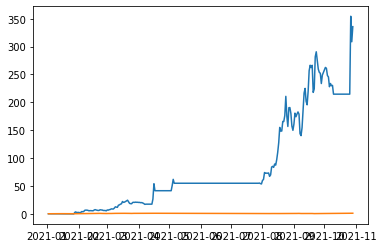

In [12]:
api = "alpha"
goods = a.sort_values("pv",ascending=False).head(10).iloc[0]
current_trades = t[(t["signal"]==goods["signal"].item())
                       & (t["req"]==goods["req"].item())
                        & (t["retrack_days"]==goods["retrack_days"].item())
                          & (t["value"]==goods["value"].item())
                            & (t["conservative"]==goods["conservative"].item())
                   & (t["entry_strategy"]==goods["entry_strategy"])
                   & (t["exit_strategy"]==goods["exit_strategy"])
                  ]
current_trades.sort_values("sell_date",inplace=True)
if current_trades.index.size > 1:
    viz = []
    row = current_trades.iloc[0]
    pv = 100
    start_date = row["date"]
    symbol = row["crypto"]
    amount = float(pv/row["buy_price"])
    end_date = row["sell_date"]
    pv2 = amount * row["sell_price"]
    viz.append({"date":start_date,"crypto":symbol,"amount":amount})
    viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    track_date = start_date
    while track_date < end_date - timedelta(days=1):
        track_date = track_date + timedelta(days=1)
        viz.append({"date":track_date,"crypto":symbol,"amount":amount})
    for i in range(1,current_trades.index.size-1):
        row = current_trades.iloc[i]
        symbol = current_trades.iloc[i]["crypto"]
        start_date = row["date"]
        pv = pv2
        amount =  pv /row["buy_price"]
        viz.append({"date":start_date,"crypto":symbol,"amount":amount})
        track_date = start_date
        end_date = row["sell_date"]
        while track_date < end_date:
            track_date = track_date + timedelta(days=1)
            viz.append({"date":track_date,"crypto":symbol,"amount":amount})
        pv2 = amount * row["sell_price"]
        viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    window = pd.DataFrame(viz)
    example = final.merge(window,how="left",on=["date","crypto"])
    example = example.dropna().sort_values("date")
    example["actual"] = example["amount"] * example["value"]
    example = example.merge(market[["date","btc"]],on="date",how="left")
    example["bench_delta"] = (example["btc"] - example["btc"].iloc[0]) / example["btc"].iloc[0]
    example["actual_delta"] = (example["actual"] - example["actual"].iloc[0]) / example["actual"].iloc[0]
#     if example["actual"].max() < 10000:
    plt.plot(example["date"],example["actual_delta"])
    plt.plot(example["date"],example["bench_delta"])
plt.show()

In [13]:
symbol_analysis = []
for symbol in current_trades["crypto"].unique():
    symbol_trades = current_trades[current_trades["crypto"]==symbol]
    trades = symbol_trades.index.size
    initial = 1
    for delta in symbol_trades["delta"]:
        initial = initial * 1+delta
    symbol_return = initial
    symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
    symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]
    symbol_analysis.append({"symbol":symbol,"return":initial,"trades":trades,"hpr":symbol_trades["days"].mean()})

C:\Users\eric\AppData\Local\Temp/ipykernel_14112/922708580.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
C:\Users\eric\AppData\Local\Temp/ipykernel_14112/922708580.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]


In [14]:
initial

1.561718098415346

In [15]:
pd.DataFrame(symbol_analysis).sort_values("return",ascending=False)

,symbol,return,trades,hpr
0,doge,9.117138,3,14.333333
1,luna,4.190033,3,27.000000
3,shib,1.561718,1,3.000000
2,avax,1.443238,1,51.000000


In [16]:
initial = 100
for delta in current_trades["delta"]:
    initial = initial * (1+delta)
    print(initial,1+delta)
initial

747.6440188478492 7.476440188478493
1821.5953463563544 2.4364474274314523
4234.034727114228 2.324355261218335
5573.440756053177 1.3163427121562232
14937.288175088332 2.680083781076404
21558.068057061464 1.443238411441706
33667.62505158264 1.561718098415346
36142.271766231606 1.0735022654807853


36142.271766231606

In [17]:
current_trades

,date,crypto,value,signal,velocity,inflection,p_sign_change,type,sell_price,sell_date,buy_price,delta,req,retrack_days,conservative,entry_strategy,exit_strategy
4627,2021-01-02,doge,False,0.3,73.284890,-19.277752,True,profit,0.078700,2021-02-08,0.010526,6.476440,0.2,3,True,all,adaptive_hold
8665,2021-02-09,luna,False,0.3,4.089039,-11.605587,True,profit,15.754800,2021-04-08,6.466300,1.436447,0.2,3,True,all,adaptive_hold
4729,2021-04-14,doge,False,0.3,2.120656,-0.636076,True,profit,0.282253,2021-04-17,0.121433,1.324355,0.2,3,True,all,adaptive_hold
4748,2021-05-03,doge,False,0.3,0.287881,-0.989274,True,profit,0.581060,2021-05-06,0.441420,0.316343,0.2,3,True,all,adaptive_hold
8834,2021-07-28,luna,False,0.3,1.646230,-4.636096,True,profit,29.430000,2021-08-19,10.981000,1.680084,0.2,3,True,all,adaptive_hold
1857,2021-08-20,avax,False,0.3,1.264608,-0.496994,True,profit,56.510000,2021-10-10,39.155000,0.443238,0.2,3,True,all,adaptive_hold
9924,2021-10-26,shib,False,0.3,1.639019,-0.165261,True,profit,0.000075,2021-10-29,0.000048,0.561718,0.2,3,True,all,adaptive_hold
8959,2021-11-30,luna,False,0.3,1.602121,-1.724799,True,profit,63.970000,2021-12-01,59.590000,0.073502,0.2,3,True,all,adaptive_hold


In [18]:
nice= pd.DataFrame(analysis)
nice.sort_values("pv",ascending=False).head(30)

,signal,req,trades,pv,days,retrack_days,value,conservative,entry_strategy,exit_strategy
886,0.3,0.2,8,36142.271766,22.250000,3,False,True,all,adaptive_hold
1848,0.3,0.4,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
888,0.3,0.4,8,36142.271766,22.250000,3,False,True,all,adaptive_hold
1849,0.3,0.5,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
885,0.3,0.1,8,36142.271766,22.250000,3,False,True,all,adaptive_hold
889,0.3,0.5,8,36142.271766,22.250000,3,False,True,all,adaptive_hold
1847,0.3,0.3,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
1846,0.3,0.2,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
1845,0.3,0.1,8,36142.271766,22.250000,3,False,False,all,adaptive_hold
887,0.3,0.3,8,36142.271766,22.250000,3,False,True,all,adaptive_hold
